### Calculating velocity distributions in verne

First, we'll load up some code that we need:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d


import verne
import MaxwellBoltzmann as MB

In [2]:
verne.loadFFcorrections(1)

>VERNE: Loading isotope data and density profiles...
>VERNE: Calculating Form Factor corrections for m_x =  1  GeV, with SI interactions...


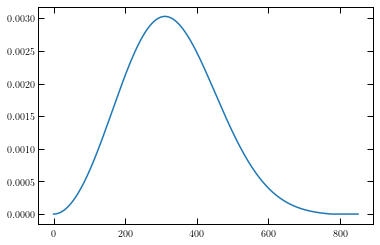

In [3]:
v_list = np.linspace(0, 850, 1000)
plt.figure()

plt.plot(v_list, MB.calcf_SHM(v_list))

plt.show()

Now let's try to calculate the velocity distribution $f(v)$ at one specific value of $v$, let's call it $v_1$:

In [4]:
v1 = 200 #km/s
#f_final = verne.CalcF(v1, gamma=0.0, depth=100, sigma_p=1e-26, m_x=1.0, target="SUF", vmax_interp=None, interaction="SI")

Okay, so the code won't let us use `None` :( So it turns out that `vmax_interp` needs to be some kind of function, which returns the maximum possible final speed at the detector $v_{f,\mathrm{max}}$, as a function of $\theta$, the incoming direction of the DM particle. What happens if we specify something very general?

In [5]:
def vmax_interp1(theta):
    return 800 #km/s

In [6]:
f_final = verne.CalcF(v1, gamma=0.3, depth=100, sigma_p=1e-30, m_x=1.0, target="SUF", vmax_interp=vmax_interp1, interaction="SI")
print(f_final)

/usr/local/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


0.0002493344846009851


Hmmm...that seems to work - let's try doing it for a range of velocities:

In [14]:
v_list = np.linspace(0, 800, 20)
%time f_final_list = [verne.CalcF(v, gamma=0.3, depth=100, sigma_p=1e-30, m_x=1.0, target="SUF", vmax_interp=vmax_interp1, interaction="SI") for v in v_list]

CPU times: user 2min 19s, sys: 2 s, total: 2min 21s
Wall time: 2min 20s


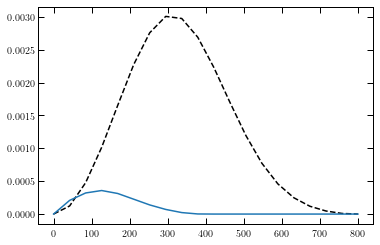

In [15]:
plt.figure()

plt.plot(v_list, MB.calcf_SHM(v_list), 'k--', label='SHM (unperturbed)')
plt.plot(v_list, f_final_list)

plt.show()

This works, but it's pretty slow. Let's calculate the maximum velocity as a function of the incoming angle $\theta$. We want to do this in advance (rather than letting `verne.CalcF` deal with it internally) because we need this function repeatedly (every time we call `verne.CalcF` for a different `v`, we don't want to have to recalculate!).

The maximum velocity at the detector corresponds to the final velocity of the DM particle which has the largest *initial* velocity. The maximum initial velocity depends on the incoming direction of the DM particle. Let's write $\mathbf{v}_g$ as the velocity of a DM particle in the galactic rest frame, $\mathbf{v}$ as the velocity of that same particle in the Earth's frame and $\mathbf{v}_e$ the velocity of the Earth with respect to the Galaxy. Then:

$$
\begin{align}
\mathbf{v}_g &= \mathbf{v} - \mathbf{v}_e\\
\Rightarrow v_g^2&= v^2 + v_e^2 - 2 \mathbf{v}\cdot \mathbf{v}_e
\end{align}
$$

To find the maximum speed in the Earth frame, we'll set $v_g = v_\mathrm{esc}$, the escape velocity in the Galactic rest frame:
$$
\begin{align}
v^2 - 2 \mathbf{v}\cdot \mathbf{v}_e + v_e^2 - v_\mathrm{esc}^2  = 0
\end{align}
$$

Based on the definitions of the angles $\gamma$ and $\theta$, you can show that the angle $\alpha$ between $\mathbf{v}$ and $\mathbf{v}_e$ is:
$$\cos\alpha = \sin\gamma\,\sin(\pi -\theta) + \cos\gamma\,\cos(\pi - \theta)$$
*(This is actually a nice exercise, to check that you understand what these angles mean).*

We finally have:
$$
\begin{align}
v^2 - 2 v\,v_e\cos\alpha + (v_e^2 - v_\mathrm{esc}^2)  = 0
\end{align}
$$
which can be solved to obtain $v$, the maximum initial velocity as a function of $\gamma$ and $\theta$. 

In [22]:
#Let's fix a value of gamma and calculate for a range of theta
#gamma = np.pi*126/180.0
gamma = 0

Nvals = 501
thetavals = np.linspace(0, np.pi, Nvals)

#Loading values from MaxwellBoltzmann module:
v_e = np.sqrt(2.0)*MB.sigmav
vesc = MB.vesc

#Solving using quadratic formula:
a = 1.0
b = 2*v_e*(-np.sin(gamma)*np.sin(np.pi-thetavals) + np.cos(gamma)*np.cos(np.pi-thetavals))
c = v_e**2 - vesc**2
v_initial_max = (-b + np.sqrt(b**2 - 4*a*c))/(2.0*a)

#Now we loop over values of theta, calculating the final velocity at the detector
        #Calculate the maximum final speed as a function of incoming angle theta
v_final_max = 0.0*v_initial_max
for i in range(Nvals):
    v_final_max[i] = verne.calcVfinal_full(v_initial_max[i], thetavals[i],  depth=0, sigma_p=1e-30, m_x=1.0, interaction="SI", target="surface")    

#Now generate an interpolation function for v_final(theta):
vmax_interp2 = interp1d(thetavals, v_final_max, kind='linear', bounds_error=False, fill_value=0)

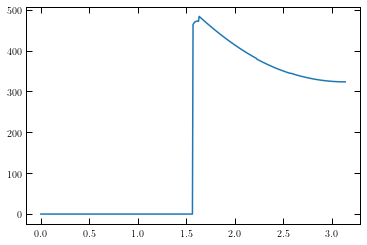

In [23]:
plt.figure()

plt.plot(thetavals, v_final_max)

plt.show()

In [24]:
#This thing works just like any other function:
print(vmax_interp2(0.75*np.pi))

364.13442869066904


**WARNING:** Note here that you should make sure that the parameters you use to calculate this interpolation function (depth, mass, cross section etc) agree with the parameters you'll use to calculate the velocity distribution. Otherwise things won't be consistent. This means you have to recalculate this interpolation function whenever you change e.g. $\gamma$.

It's possible that there's a more refined way of doing all this, but for the moment, this saves the code having to store these things internally...

Now let's try calculating things again, using this more accurate function for v_max(theta):

In [27]:
v_list = np.linspace(0, 800, 50)
%time f_final_SI_list = [verne.CalcF(v, gamma=gamma, depth=0, sigma_p=1e-30, m_x=1.0, target="surface", vmax_interp=vmax_interp2, interaction="SI") for v in v_list]

/usr/local/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


CPU times: user 18.3 s, sys: 421 ms, total: 18.8 s
Wall time: 18.6 s


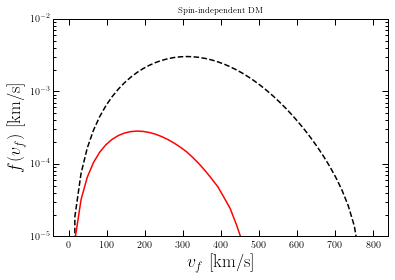

In [142]:
plt.figure()

plt.semilogy(v_list, MB.calcf_SHM(v_list), 'k--', label='SHM (unperturbed)')
#plt.plot(v_list, f_final_list, 'b-')
plt.plot(v_list, f_final_SI_list, 'r-')

plt.xlabel(r"$v_f$ [km/s]")
plt.ylabel(r"$f(v_f)$ [km/s]")

plt.title("Spin-independent DM")


plt.ylim(1e-5, 1e-2)
plt.show()

Great! That's now faster, because the code isn't wasting time calculating for speeds which are unphysically large!

## Millicharged DM

See Sec. 3 of https://arxiv.org/abs/1804.03073 for more details. There, we see that the total cross section for Millicharged DM scattering of a nucleus $(A, Z)$ is given by:

$$ \sigma_{A}(v)=\frac{4 \pi Z_{A}^{2} \epsilon^{2} \alpha^{2}}{v^{2}}\left(\frac{1}{m_{e}^{2} \alpha^{2}}-\frac{1}{4 \mu_{A}^{2} v^{2}}\right) $$

This equation is only valid for $v > v_\mathrm{screen} = \alpha m_e/(2\mu_{\chi A})$. Below this speed, the DM particles can only exchange a small amount of momentum with the nucleus. This means that they do not see the internal structure of the atom (with a point-charge nucleus), but rather they see the whole atom coherently, as a neutral object. Expressed another way, the cloud of electrons 'screen' the charge of the nucleus for low momentum-transfer (or low speeds). The cross section therefore drops to zero as $v < v_\mathrm{screen}$.

Note here that we are neglecting Millicharged DM scattering off electrons (which may be important in some cases - see e.g. https://arxiv.org/abs/1905.06348). 

Let's investigate the stopping of a 5 GeV millicharged particle:

In [7]:
m_x = 5.0

In [8]:
verne.loadFFcorrections(m_x, interaction='millicharge')

>VERNE: Calculating Form Factor corrections for m_x =  5.0  GeV, with millicharge interactions...


In [9]:
vi_list = np.linspace(0, 1000)
vf_list = 0.0*vi_list

for i, vi in enumerate(vi_list):
    vf_list[i] = verne.calcVfinal_full(vi, theta=np.pi/2, depth=0, sigma_p=1e-30, m_x=m_x, interaction="millicharge", target="surface")  

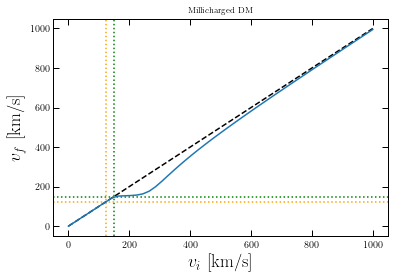

In [10]:
plt.figure()

#Let's calculate the screening velocity. In fact, each nucleus has a different screening velocity...
m_O = 0.93*16 #Mass in GeV of an Oxygen nucleus
mu_XO = m_O*m_x/(m_O + m_x)
v_screen_O = (3e5)*verne.alpha*verne.m_e/(2*mu_XO)

m_Fe = 0.93*56 #Mass in GeV of an Iron nucleus
mu_XFe = m_Fe*m_x/(m_Fe + m_x)
v_screen_Fe = (3e5)*verne.alpha*verne.m_e/(2*mu_XFe)
#^Factor of 3e5 converts from dimensionless units to km/s (because the speed of light is c = 3e5 km/s)

plt.axhline(v_screen_O, linestyle=':', color='green')
plt.axvline(v_screen_O, linestyle=':', color='green')

plt.axhline(v_screen_Fe, linestyle=':', color='orange')
plt.axvline(v_screen_Fe, linestyle=':', color='orange')

plt.plot(vi_list, vi_list, color='k', linestyle='--')
plt.plot(vi_list, vf_list)

plt.xlabel(r'$v_i$ [km/s]')
plt.ylabel(r'$v_f$ [km/s]')

plt.title("Millicharged DM")

plt.show()

Q: Looking at the cross sections for milli-charged DM scattering with nuclei, why does this curve have this shape?

Anyway, let's now look at a velocity distribution:

In [18]:
#Let's fix a value of gamma and calculate for a range of theta
#gamma = 0.0
gamma = (168/180)*np.pi

Nvals = 501
thetavals = np.linspace(0, np.pi, Nvals)

#Loading values from MaxwellBoltzmann module:
v_e = np.sqrt(2.0)*MB.sigmav
vesc = MB.vesc

#Solving using quadratic formula:
a = 1.0
b = 2*v_e*(-np.sin(gamma)*np.sin(np.pi-thetavals) + np.cos(gamma)*np.cos(np.pi-thetavals))
c = v_e**2 - vesc**2
v_initial_max = (-b + np.sqrt(b**2 - 4*a*c))/(2.0*a)

#Now we loop over values of theta, calculating the final velocity at the detector
        #Calculate the maximum final speed as a function of incoming angle theta
v_final_max = 0.0*v_initial_max
for i in range(Nvals):
    v_final_max[i] = verne.calcVfinal_full(v_initial_max[i], thetavals[i],  depth=10.6, sigma_p=1e-28, m_x=m_x, interaction="millicharge", target="full")    

#Now generate an interpolation function for v_final(theta):
vmax_interp2 = interp1d(thetavals, v_final_max, kind='linear', bounds_error=False, fill_value=0)

In [19]:
v_list = np.linspace(0, 800, 100)
%time f_final_MC_list = [verne.CalcF(v, gamma=gamma, depth=10.6, sigma_p=1e-28, m_x=m_x, target="full", vmax_interp=vmax_interp2, interaction="millicharge") for v in v_list]

CPU times: user 1min 19s, sys: 1.05 s, total: 1min 20s
Wall time: 1min 20s


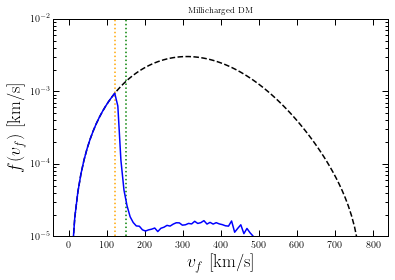

In [20]:
plt.figure()

plt.axvline(v_screen_O, linestyle=':', color='green')
plt.axvline(v_screen_Fe, linestyle=':', color='orange')

plt.semilogy(v_list, MB.calcf_SHM(v_list), 'k--', label='SHM (unperturbed)')
#plt.plot(v_list, f_final_list, 'b-')
plt.plot(v_list, f_final_MC_list, 'b-')

plt.xlabel(r"$v_f$ [km/s]")
plt.ylabel(r"$f(v_f)$ [km/s]")

plt.title("Millicharged DM")

plt.ylim(1e-5, 1e-2)
plt.show()

Note that the distribution function is now not normalised to 1. Where did all the extra particles go? They didn't go anywhere, but a lot of particles will have been slowed down until they reach the screening velocity (or rather, the smallest screening velocity of all the nuclei in the Earth). At this point, the cross section for interaction drops to zero, so they don't lose any more velocity. Another way of expressing this is that $\mathrm{d}v_i/\mathrm{d}v_f \rightarrow \infty$ at $v_\mathrm{screen}$, meaning that our formalism breaks down. 

Generally, $v_\mathrm{screen}$ may be small enough that it doesn't affect the recoil rate (because it may be below the velocity required kinematically for a detectable recoil). So we may not have to worry about it. But the alternative is to add in - 'by hand' - a population of DM particles with velocity $v = v_\mathrm{screen}$, such that the normalisation of the speed distribution is 1 again.

------------
**A note on the 'cross-section' for millicharged DM:**

As can be seen above, the cross section for millicharged DM is velocity-dependent, so it's hard to define a 'total cross section' in the same way as for spin-independent DM. However, we can define a 'reference cross-section' $\sigma_\mathrm{ref}$, evaluated as the DM-proton cross-section at some (arbitrary) reference value of $v_\mathrm{ref} = \sqrt{2} m_e \alpha/(2\mu_{\chi p})$:

$$\sigma_\mathrm{ref} = \frac{4 \pi \epsilon^2 \mu_{\chi p}^2}{m_e^4 \alpha^2}$$

This is the cross-section that `verne` accepts as input for calculating the stopping effect for millicharged DM. It should be straight-forward to convert between $\epsilon$ and $\sigma_\mathrm{ref}$ if required.